In [ ]:
%pip install pingouin

In [ ]:
%pip install lazypredict

In [2]:
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
from scipy.stats import skew
import scipy.stats as st
import sidetable
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import kurtosistest
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor

# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

# Objectives
Description of data, identification of variables to be taken into account for the calculation of health insurance premiums.

Predict amount of charges

In [18]:
df = pd.read_csv("../data/00-insurance.csv", index_col = 0).reset_index()
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55


## Understand the variables we have and what our dataframe looks like.

In [320]:
# number of rows and columns in the dataframe

df.shape

(1338, 7)

In [321]:
# general data frame information

df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1338 entries, 0 to 1337
,Data columns (total 7 columns):
, #   Column    Non-Null Count  Dtype  
,---  ------    --------------  -----  
, 0   age       1338 non-null   int64  
, 1   sex       1338 non-null   object 
, 2   bmi       1338 non-null   float64
, 3   children  1338 non-null   int64  
, 4   smoker    1338 non-null   object 
, 5   region    1338 non-null   object 
, 6   charges   1338 non-null   float64
,dtypes: float64(2), int64(2), object(3)
,memory usage: 73.3+ KB


In [322]:
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [323]:
# duplicates

df.duplicated().sum()

1

In [324]:
df[df.duplicated()== True] 

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.56


In [19]:
df.drop_duplicates(inplace=True)

In [326]:
df.to_csv('insurance_ok.csv')

### Statistics

In [327]:
# leading statistics of the numeric columns.

df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1337.00,1337,1337.00,1337.00,1337,1337,1337.00
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,675,NaN,NaN,1063,364,NaN
mean,39.22,NaN,30.66,1.10,NaN,NaN,13279.12
std,14.04,NaN,6.10,1.21,NaN,NaN,12110.36
min,18.00,NaN,15.96,0.00,NaN,NaN,1121.87
25%,27.00,NaN,26.29,0.00,NaN,NaN,4746.34
50%,39.00,NaN,30.40,1.00,NaN,NaN,9386.16
75%,51.00,NaN,34.70,2.00,NaN,NaN,16657.72


Data info:
- Smoking habits, majority non-smokers (274 smokers)
- BMI mean 30, overweight (more than 75% over BMI 25)

# Outliers

In [328]:
numericas = df.select_dtypes(include=np.number)
numericas

,age,bmi,children,charges
0,19,27.90,0,16884.92
1,18,33.77,1,1725.55
2,28,33.00,3,4449.46
3,33,22.70,0,21984.47
4,32,28.88,0,3866.86
...,...,...,...,...
1333,50,30.97,3,10600.55
1334,18,31.92,0,2205.98
1335,18,36.85,0,1629.83
1336,21,25.80,0,2007.94


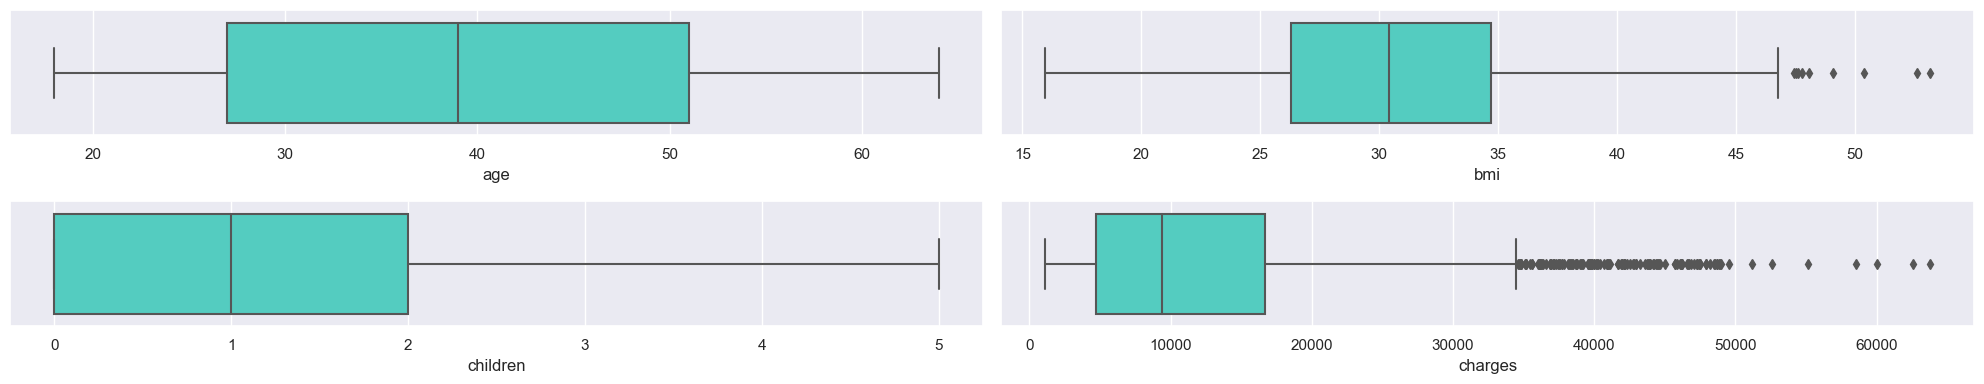

In [329]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise") 
plt.tight_layout()
plt.show();

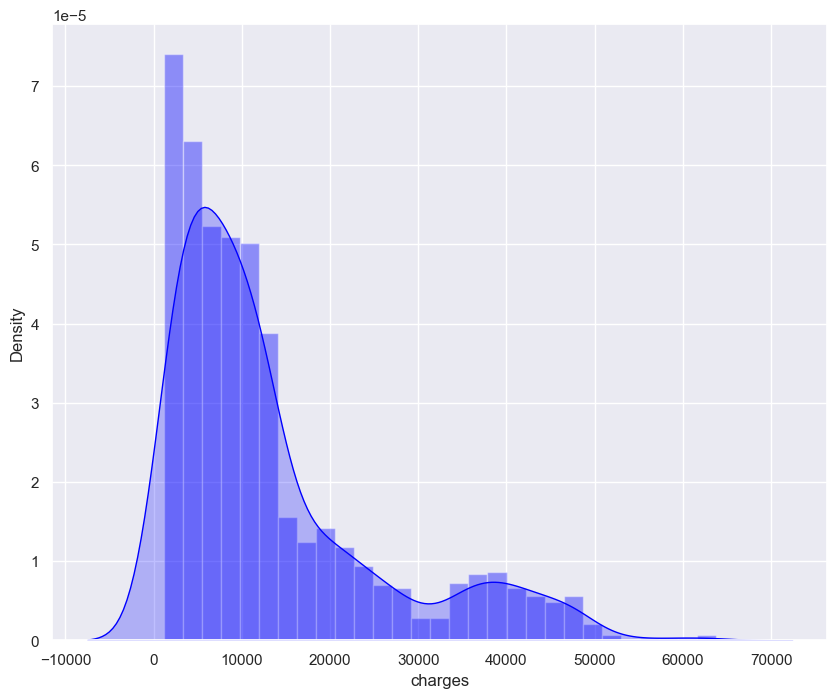

In [330]:
# I'm going to look at the distribution of variable charges
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df["charges"], 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});


### Not normal

## We analyse the numerical variables of the dataset

### Distributions

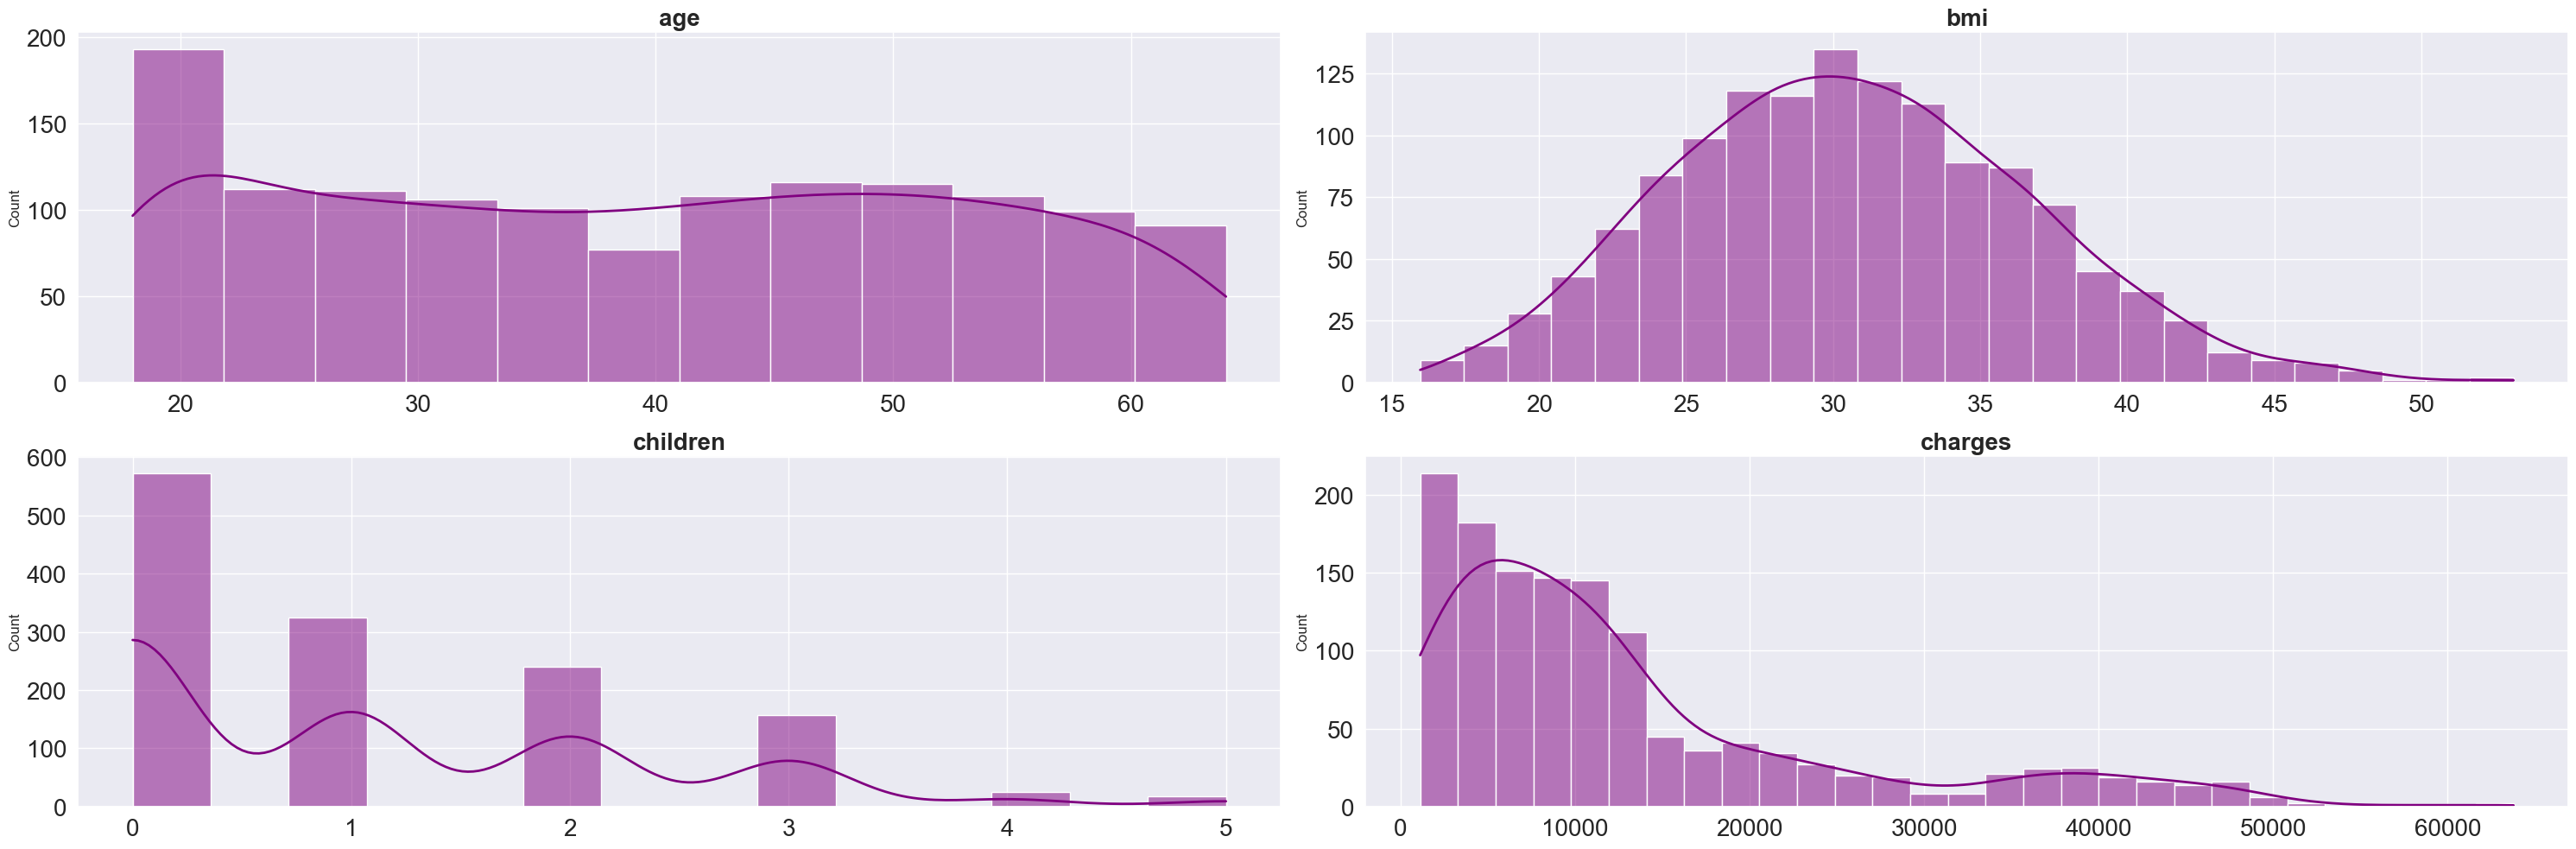

In [331]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterator
for i, colum in enumerate(numericas.columns): 
    sns.histplot(
        data = numericas[colum],
        kde = True,
        color = "purple", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

### Relationship to the response variable

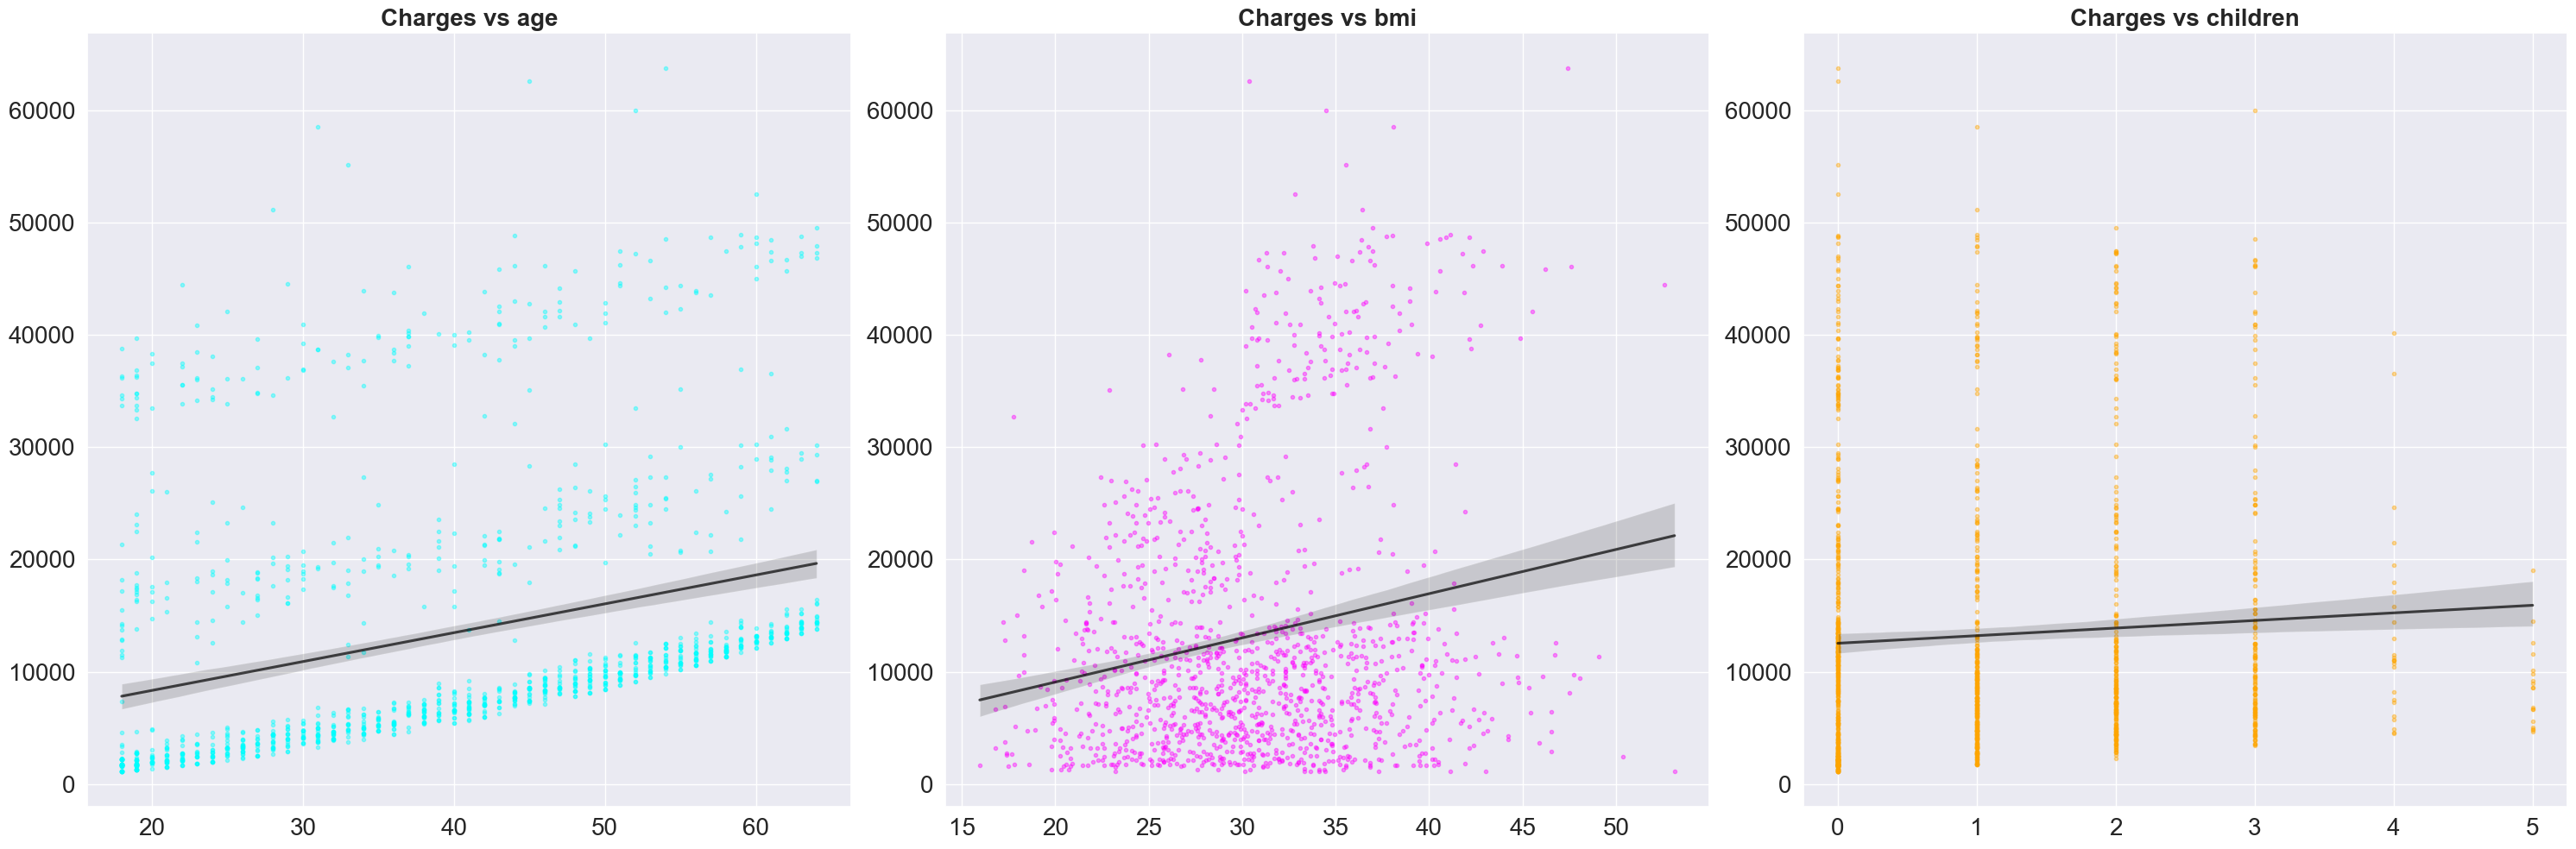

In [332]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
lista_colores = ["cyan", "magenta", "orange"]

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = lista_colores[i], 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();


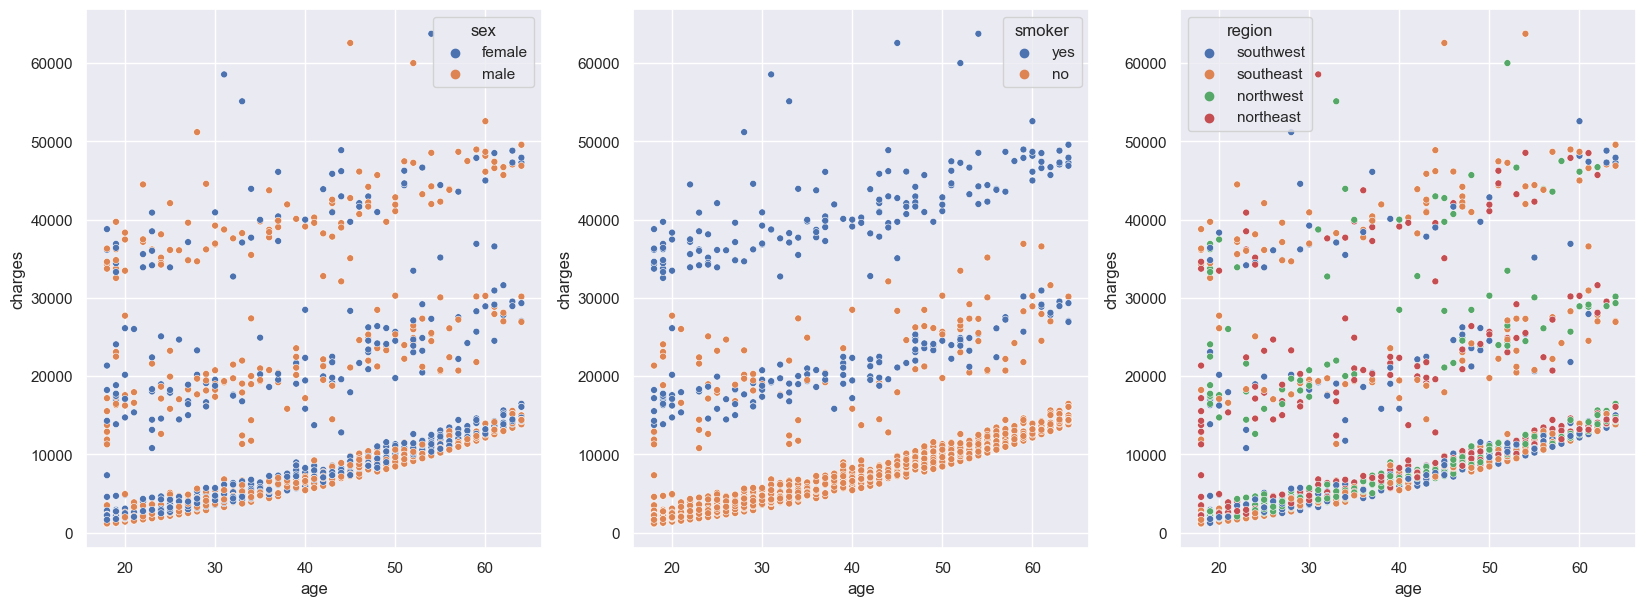

In [333]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

Here we see that in age, there are about three clear trend lines in the distribution of our data.  
**-------------------------------------All 3 increase with age and tobacco-------------------------------------**

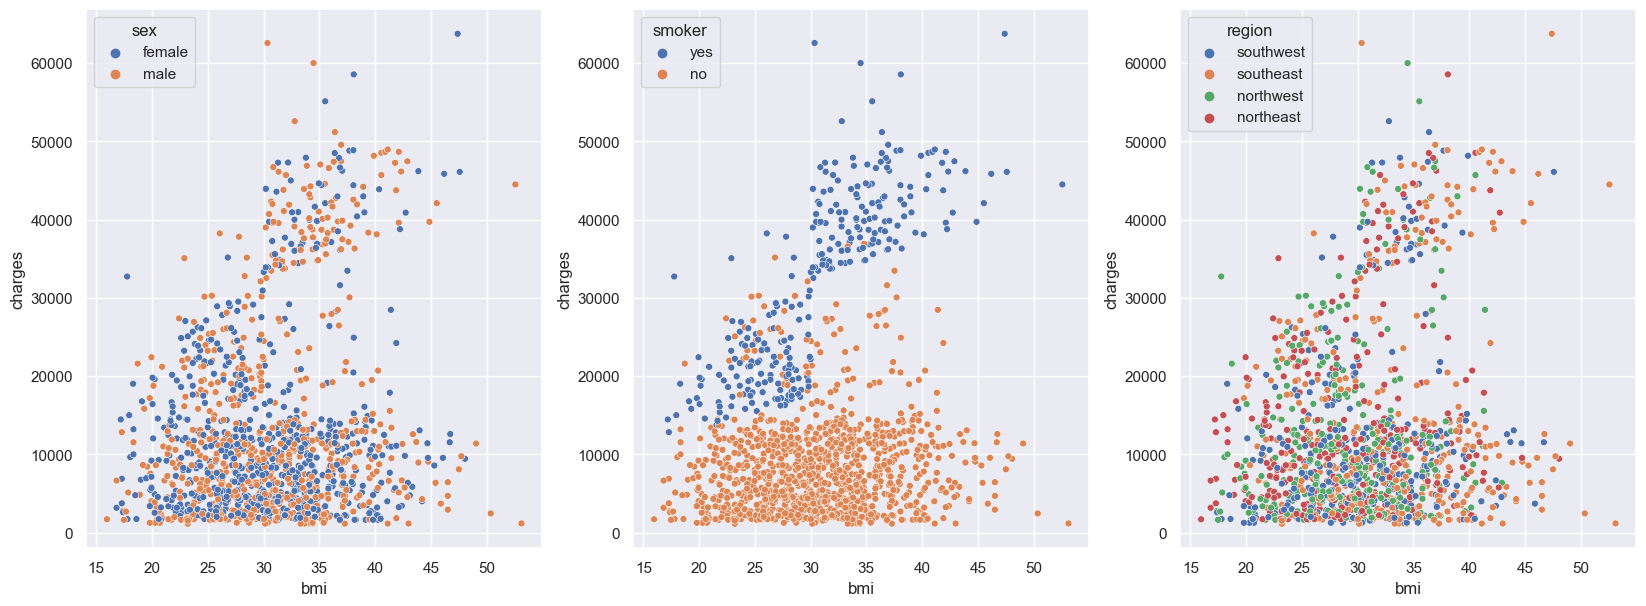

In [334]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))

for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df,
                    s = 25,    
                    hue = categoricas.columns[i], 
                    ax=axes[i])  
plt.show(); 

**-------------------------------We see that there is a clear increase  in charges with tobacco--------------------------**

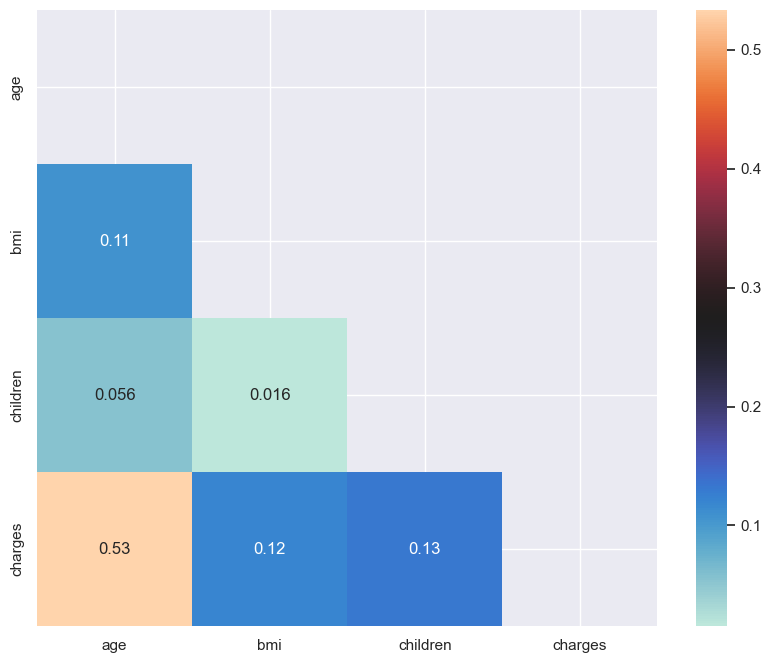

In [335]:
mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
sns.heatmap(df.corr(method='spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

## Categorical variables

### I create some graphs to go deeper into the data

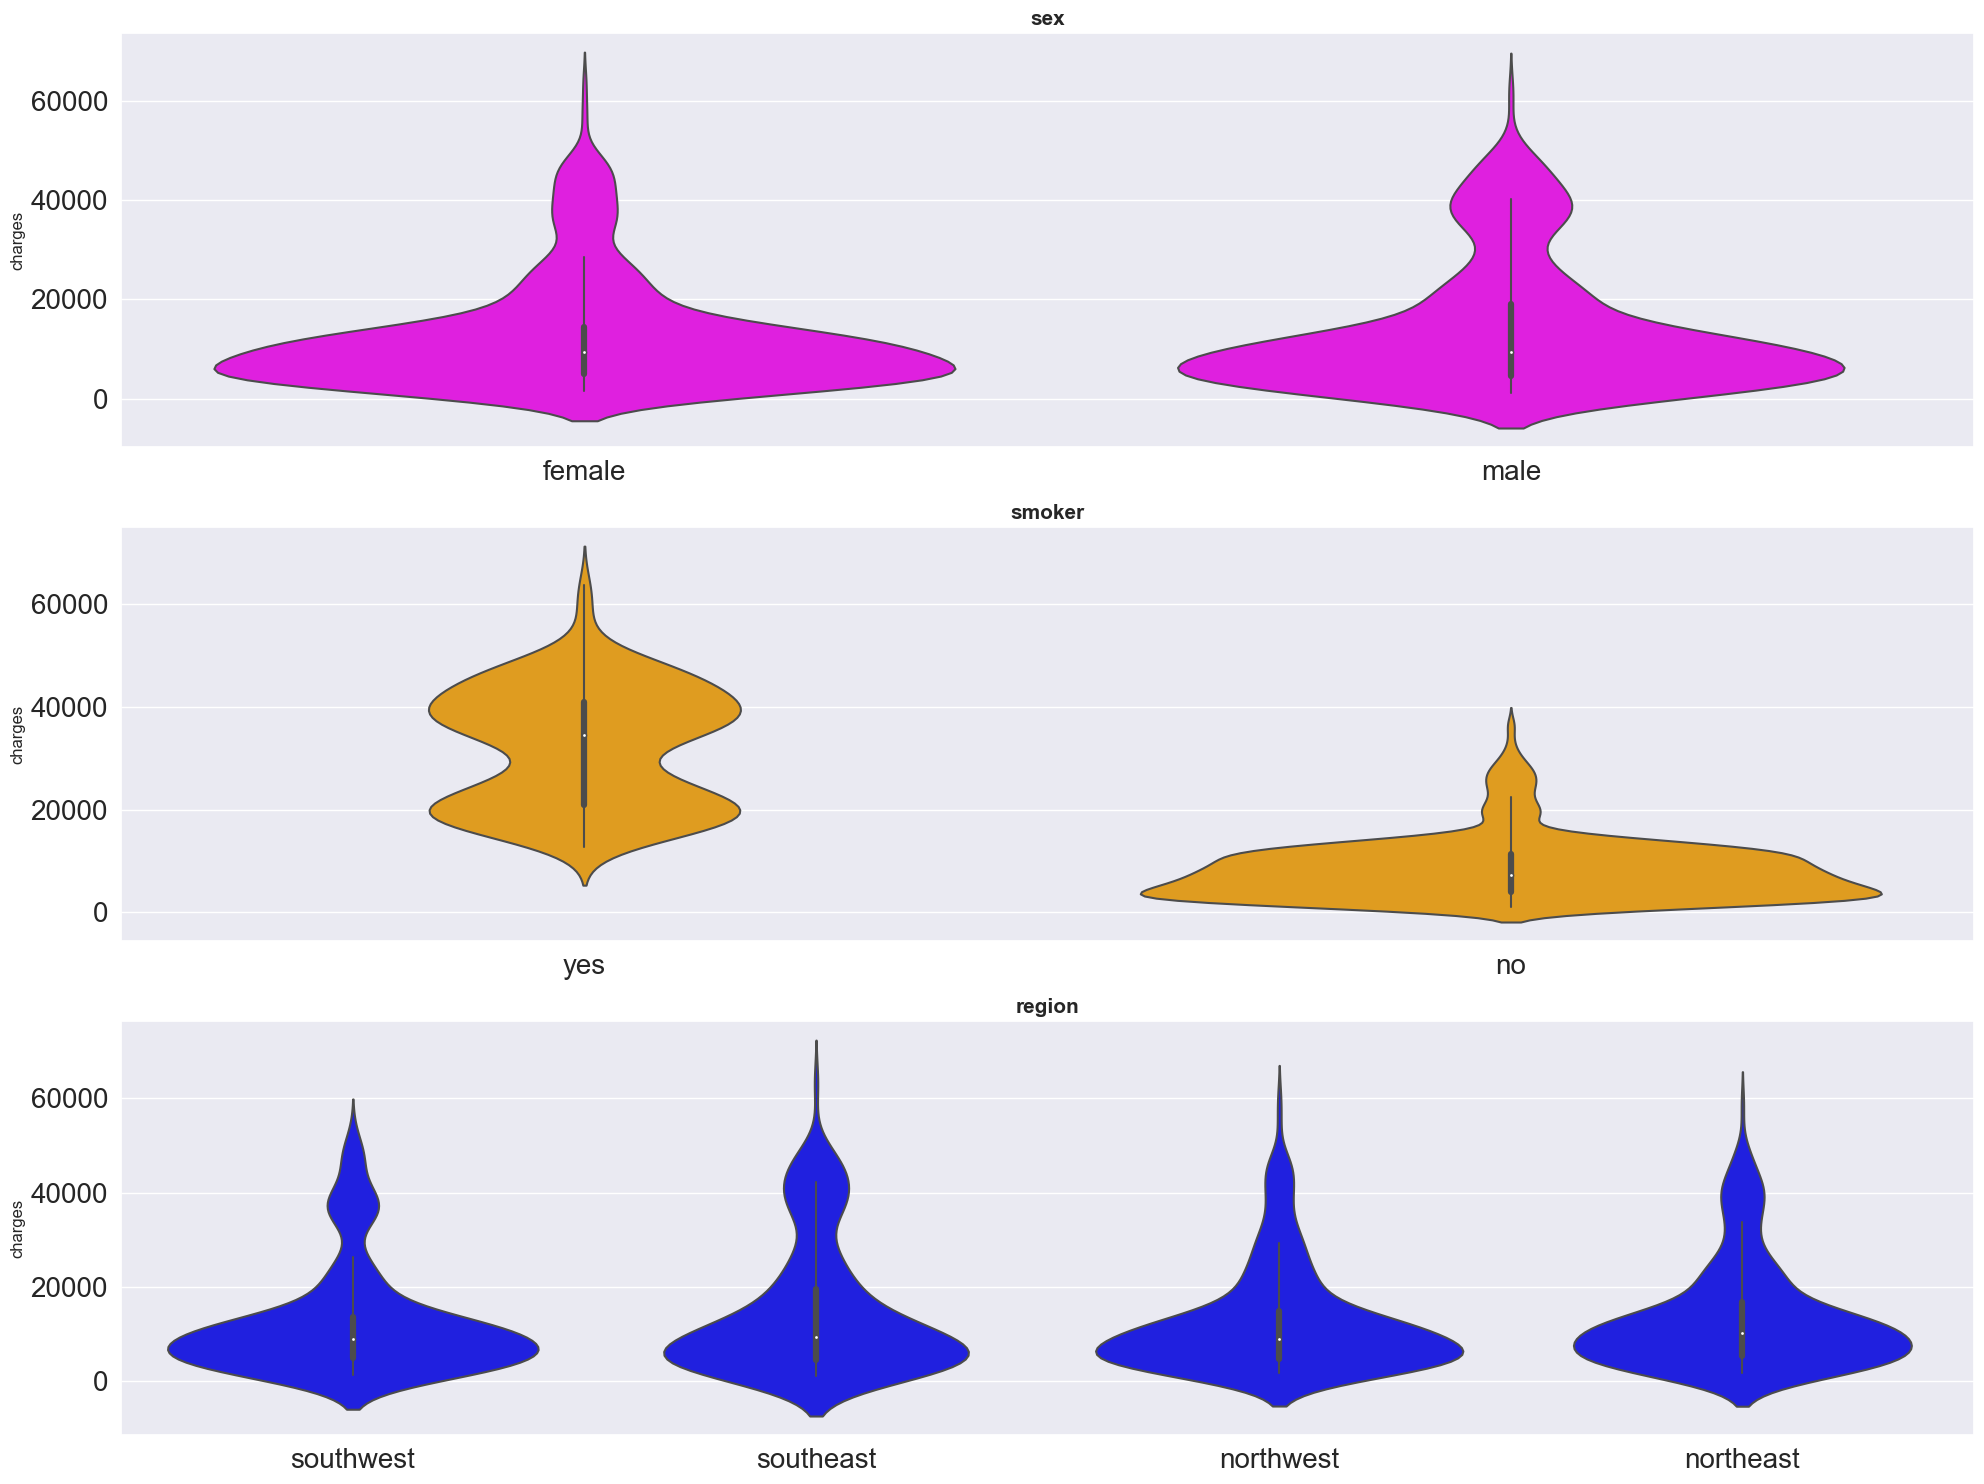

In [336]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
axes = axes.flat
lista_colores = [ "magenta", "orange","blue", "green"]
columnas = df.select_dtypes(include = 'object')
columnas = columnas.columns
for i, colum in enumerate(columnas): 
    sns.violinplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout();

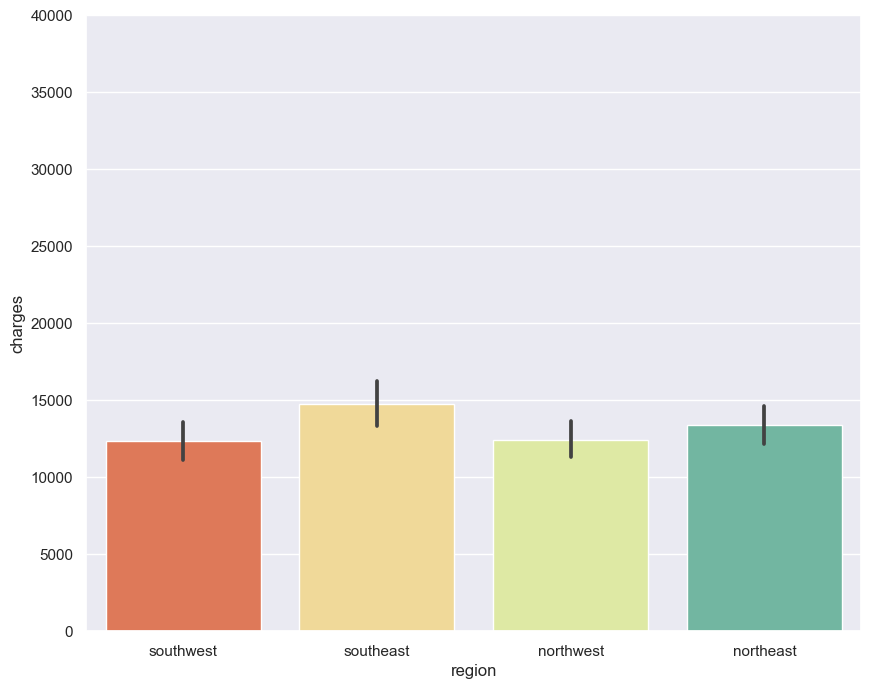

In [337]:
sns.barplot(x='region', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

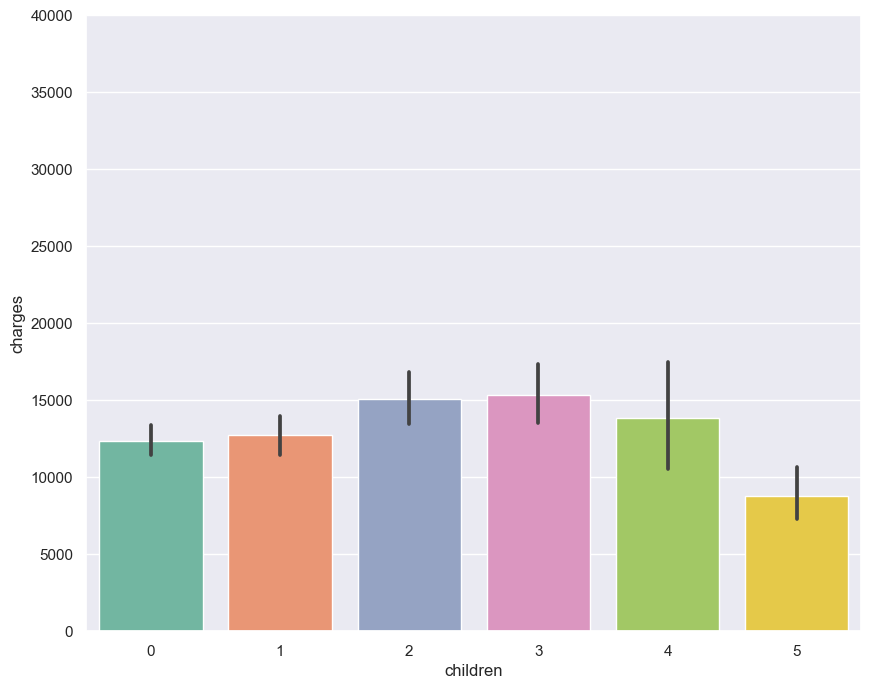

In [338]:
sns.barplot(x='children', y='charges', data=df, palette='Set2')
plt.ylim(0,40000);

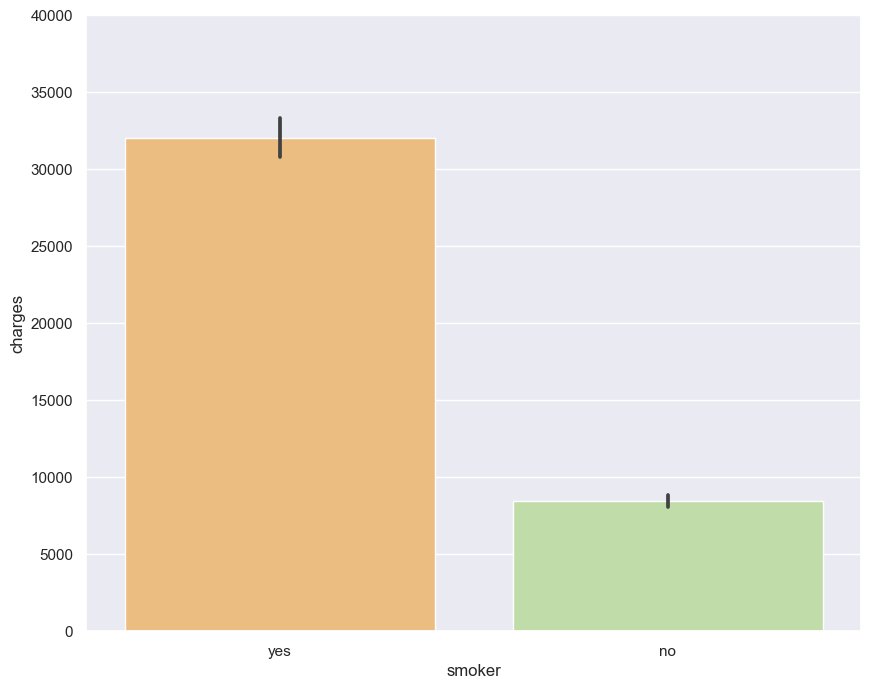

In [339]:
sns.barplot(x='smoker', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

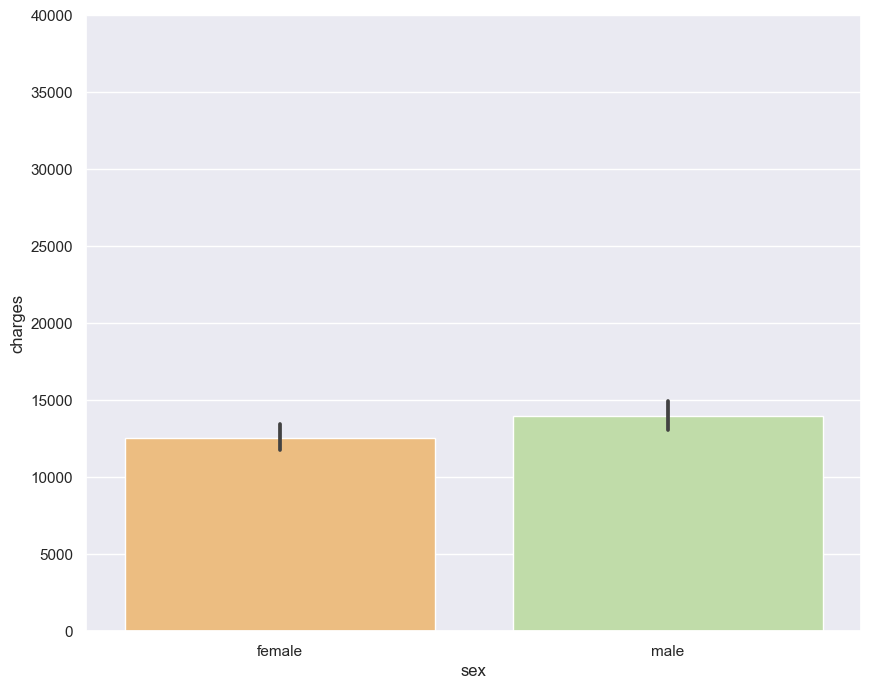

In [340]:
sns.barplot(x='sex', y='charges' ,data=df, palette='Spectral')
plt.ylim(0,40000);

modelo

In [20]:
df['sex'] = df['sex'].map({'female':0,'male':1})
df['smoker'] = df['smoker'].map({'no':0,'yes':1})
df['region'] = df['region'].map({'northeast':1,'northwest':2,'southeast':3,'southwest':4})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,4,16884.92
1,18,1,33.77,1,0,3,1725.55
2,28,1,33.00,3,0,3,4449.46
3,33,1,22.70,0,0,2,21984.47
4,32,1,28.88,0,0,2,3866.86


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
,Int64Index: 1337 entries, 0 to 1337
,Data columns (total 7 columns):
, #   Column    Non-Null Count  Dtype  
,---  ------    --------------  -----  
, 0   age       1337 non-null   int64  
, 1   sex       1337 non-null   int64  
, 2   bmi       1337 non-null   float64
, 3   children  1337 non-null   int64  
, 4   smoker    1337 non-null   int64  
, 5   region    1337 non-null   int64  
, 6   charges   1337 non-null   float64
,dtypes: float64(2), int64(5)
,memory usage: 83.6 KB


In [404]:
X = df.drop('charges',axis=1)
y = df['charges']

In [405]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [406]:
from lazypredict.Supervised import LazyRegressor

In [346]:
clf = LazyRegressor(verbose=0)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
models

100%|██████████| 42/42 [00:33<00:00,  1.24it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.90,0.90,4262.66,0.19
HistGradientBoostingRegressor,0.89,0.89,4513.08,0.63
LGBMRegressor,0.88,0.89,4548.47,0.10
BaggingRegressor,0.88,0.88,4620.42,0.07
RandomForestRegressor,0.88,0.88,4664.23,0.50
XGBRegressor,0.87,0.87,4901.26,0.15
KNeighborsRegressor,0.86,0.86,4989.34,0.02
ExtraTreesRegressor,0.85,0.85,5273.32,0.40
PoissonRegressor,0.83,0.83,5511.73,0.02


In [407]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

In [408]:
# iniciamos la regresión lineal. n_jobs hace referencia al número de nucleos que usaremos de nuestro ordenador. Al indicar -1 significa
#  que los usaremos todos. 

lr = LinearRegression(n_jobs=-1)

In [409]:
# fitear el modelo

lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [410]:
# predicciones 

y_predict_train = lr.predict(x_train) # hacemos las predicciones para las casas que tenemos en el los datos de entrenamiento
y_predict_test = lr.predict(x_test) # hacemos las predicciones para las casas que tenemos en los datos de test

In [414]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_predict_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test)})
resultados = pd.concat([train_df,test_df], axis = 0)
resultados.head()

,Real,Predicted,Set
1114,2396.10,2236.24,Train
968,3279.87,3193.03,Train
599,33471.97,14449.32,Train
170,13405.39,17013.40,Train
275,9715.84,10027.87,Train


In [352]:
resultados['residuos'] = resultados['Real'] - resultados['Predicted']
resultados.head()

,Real,Predicted,Set,residuos
1114,2396.10,2236.24,Train,159.86
968,3279.87,3193.03,Train,86.84
599,33471.97,14449.32,Train,19022.66
170,13405.39,17013.40,Train,-3608.01
275,9715.84,10027.87,Train,-312.03


In [418]:
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test),'MAE': mean_absolute_error(y_test, y_predict_test),'MSE': mean_squared_error(y_test, y_predict_test),'RMSE': np.sqrt(mean_squared_error(y_test, y_predict_test)),'R2':  r2_score(y_test, y_predict_test),"modelo": "LinearRegression"})

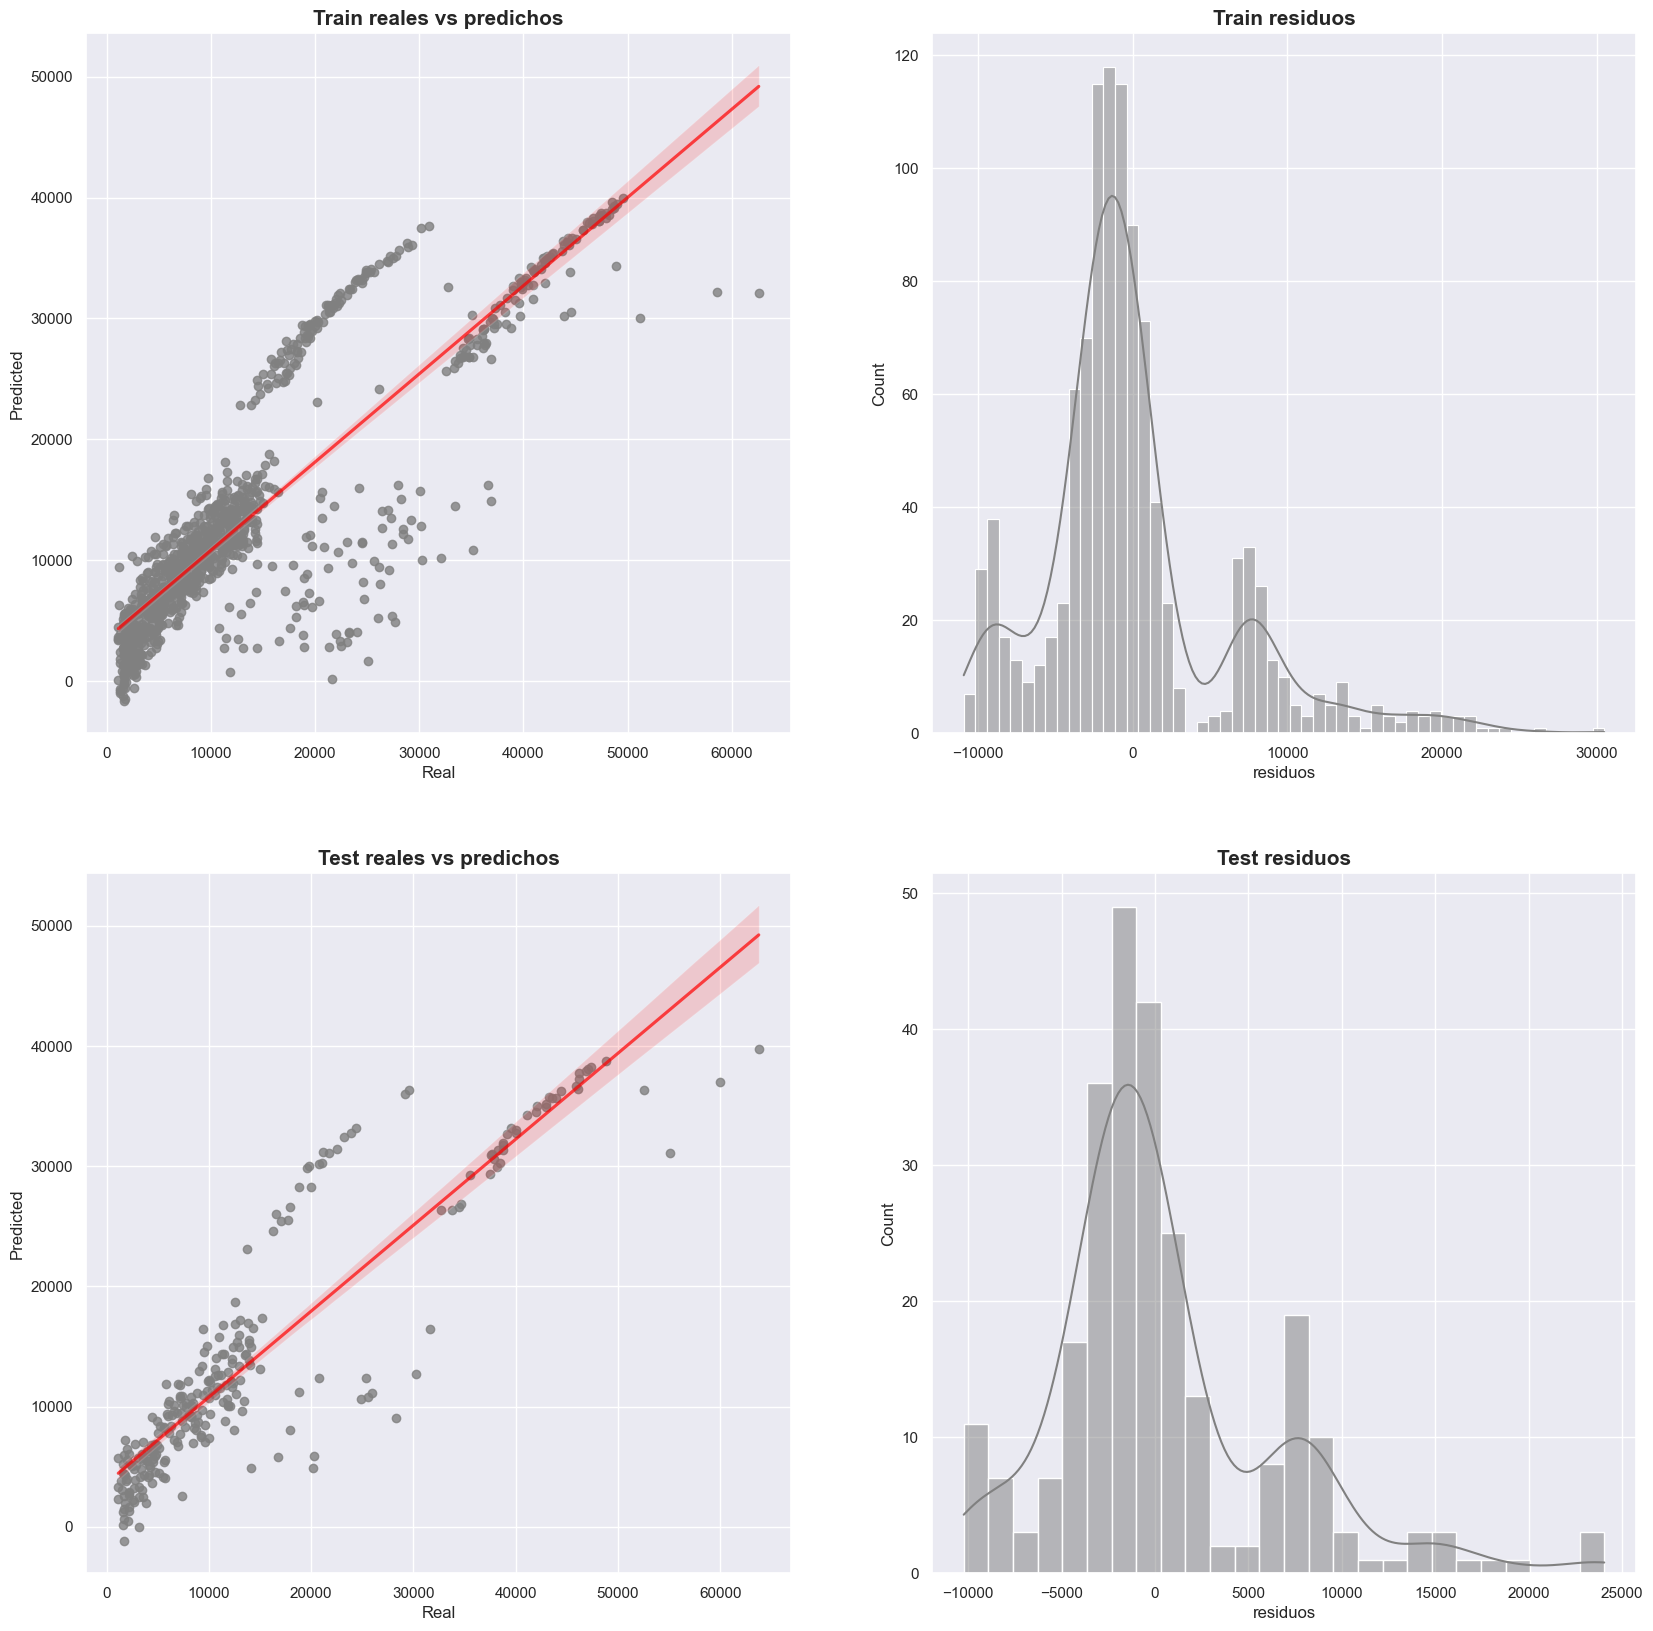

In [353]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = resultados[resultados['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = resultados[resultados['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(resultados[resultados['Set'] == "Train"],
             x="residuos",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(resultados[resultados['Set'] == "Test"],
             x="residuos",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");


In [354]:
resultados_metricas = {'MAE': [mean_absolute_error(y_test, y_predict_test), mean_absolute_error(y_train, y_predict_train)],
                'MSE': [mean_squared_error(y_test, y_predict_test), mean_squared_error(y_train, y_predict_train)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_predict_test)), np.sqrt(mean_squared_error(y_train, y_predict_train))],
                'R2':  [r2_score(y_test, y_predict_test), r2_score(y_train, y_predict_train)],
                 "set": ["test", "train"], 
                 "modelo": ["Linear Regresion", "LinearRegression"]}

df_resultados = pd.DataFrame(resultados_metricas)

df_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,4182.35,35493102.61,5957.61,0.81,test,Linear Regresion
1,4181.32,37005531.73,6083.22,0.73,train,LinearRegression


In [419]:
from sklearn.preprocessing import StandardScaler

In [420]:
# Standardize the dataset
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [423]:
# Hyperparameters for GradientBoostingRegressor

gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'absolute_error'}

In [424]:
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(x_train_std, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          min_samples_split=5, n_estimators=1000)

In [ ]:
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(x_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(x_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
#
rmse= np.sqrt(mean_squared_error(y_test, x_test_std))

Model Accuracy: 0.822
,The mean squared error (MSE) on test set: 32671538.8388


Smokers

In [429]:
dffum = df[(df['smoker'] == 1)]
dffum

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,4,16884.92
11,62,0,26.29,0,1,3,27808.73
14,27,1,42.13,0,1,3,39611.76
19,30,1,35.30,0,1,4,36837.47
23,34,0,31.92,1,1,1,37701.88
...,...,...,...,...,...,...,...
1313,19,0,34.70,2,1,4,36397.58
1314,30,0,23.66,3,1,2,18765.88
1321,62,1,26.70,0,1,1,28101.33
1323,42,0,40.37,2,1,3,43896.38


In [430]:
X_fum = dffum.drop('charges',axis=1)
y_fum= dffum['charges']

In [431]:
from sklearn.model_selection import train_test_split
X_train_fum, X_test_fum, y_train_fum, y_test_fum = train_test_split( X_fum, y_fum, test_size=0.2, random_state=42)
X_train_fum.shape, X_test_fum.shape

((219, 6), (55, 6))

In [358]:
clf_fum = LazyRegressor(verbose=0)
models_fum,predictions_fum = clf_fum.fit(X_train_fum, X_test_fum, y_train_fum, y_test_fum)
models_fum

100%|██████████| 42/42 [00:02<00:00, 17.92it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.87,0.89,4087.20,0.08
BaggingRegressor,0.87,0.89,4133.33,0.09
RandomForestRegressor,0.87,0.89,4149.35,0.24
GradientBoostingRegressor,0.86,0.88,4298.51,0.11
HistGradientBoostingRegressor,0.86,0.87,4342.74,0.21
ExtraTreesRegressor,0.85,0.86,4512.81,0.16
LGBMRegressor,0.84,0.86,4553.20,0.05
DecisionTreeRegressor,0.79,0.81,5299.05,0.02
AdaBoostRegressor,0.77,0.79,5593.13,0.10


Non Smokers

In [359]:
dfnfum = df[(df['smoker'] == 0)]
dfnfum.sample(5)

,age,sex,bmi,children,smoker,region,charges
414,19,0,35.15,0,0,2,2134.90
492,18,0,25.08,0,0,1,2196.47
1193,48,0,36.58,0,0,2,8671.19
797,30,0,22.89,1,0,1,4719.52
693,24,1,23.66,0,0,2,2352.97


In [360]:
X_nfum = dfnfum.drop('charges',axis=1)
y_nfum= dfnfum['charges']

In [361]:
from sklearn.model_selection import train_test_split
X_train_nfum, X_test_nfum, y_train_nfum, y_test_nfum = train_test_split( X_nfum, y_nfum, test_size=0.2, random_state=42)
X_train_nfum.shape, X_test_nfum.shape

((850, 6), (213, 6))

In [362]:
clf_nfum = LazyRegressor(verbose=0)
models_nfum,predictions_nfum = clf_nfum.fit(X_train_nfum, X_test_nfum, y_train_nfum, y_test_nfum)
models_nfum

100%|██████████| 42/42 [00:10<00:00,  3.97it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoCV,0.38,0.40,4712.83,0.07
Lasso,0.38,0.40,4712.91,0.02
LassoLars,0.38,0.40,4712.91,0.01
LassoLarsCV,0.38,0.40,4712.93,0.03
Lars,0.38,0.40,4712.93,0.02
LassoLarsIC,0.38,0.40,4712.93,0.01
LarsCV,0.38,0.40,4712.93,0.02
LinearRegression,0.38,0.40,4712.93,0.01
TransformedTargetRegressor,0.38,0.40,4712.93,0.02


Healthy BMI

In [428]:
df_bmi_ok = df[(df['bmi']<=25)]
df_bmi_ok.sample(5)

,age,sex,bmi,children,smoker,region,charges
266,40,1,19.80,1,1,3,17179.52
411,44,0,20.23,1,1,1,19594.81
326,27,0,23.21,1,0,3,3561.89
15,19,1,24.60,1,0,4,1837.24
1316,19,0,20.60,0,0,4,1731.68


In [393]:
X_bmi_ok = df_bmi_ok.drop('charges',axis=1)
y_bmi_ok= df_bmi_ok['charges']

In [394]:
from sklearn.model_selection import train_test_split
X_train_bmi_ok, X_test_bmi_ok, y_train_bmi_ok, y_test_bmi_ok = train_test_split( X_bmi_ok, y_bmi_ok, test_size=0.2, random_state=42)
X_train_bmi_ok.shape, X_test_bmi_ok.shape

((197, 6), (50, 6))

In [395]:
clf_bmi_ok = LazyRegressor(verbose=0)
models_bmi_ok,predictions_bmi_ok = clf_bmi_ok.fit(X_train_bmi_ok, X_test_bmi_ok, y_train_bmi_ok, y_test_bmi_ok)
models_bmi_ok

100%|██████████| 42/42 [00:02<00:00, 17.46it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
OrthogonalMatchingPursuitCV,0.46,0.53,5631.86,0.02
LassoCV,0.46,0.52,5647.35,0.09
SGDRegressor,0.46,0.52,5647.49,0.02
Lasso,0.46,0.52,5648.44,0.03
LassoLars,0.46,0.52,5648.44,0.02
LarsCV,0.46,0.52,5648.71,0.03
LassoLarsCV,0.46,0.52,5648.71,0.03
LassoLarsIC,0.46,0.52,5648.71,0.02
Lars,0.46,0.52,5648.71,0.03


Unhealthy BMI

In [367]:
df = pd.read_csv("../data/00-insurance.csv", index_col = 0).reset_index()
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55


In [368]:
df.drop_duplicates(inplace=True)

In [369]:
df['sex'] = df['sex'].map({'female':0,'male':1})
df['smoker'] = df['smoker'].map({'no':0,'yes':5})
df['region'] = df['region'].map({'northeast':3,'northwest':1,'southeast':4,'southwest':2})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,5,2,16884.92
1,18,1,33.77,1,0,4,1725.55
2,28,1,33.00,3,0,4,4449.46
3,33,1,22.70,0,0,1,21984.47
4,32,1,28.88,0,0,1,3866.86


In [381]:
df_bmi_nok = df[(df['bmi'] >25)]
df_bmi_nok.sample(5)

,age,sex,bmi,children,smoker,region,charges
480,63,1,41.33,3,0,1,15555.19
285,46,1,26.62,1,0,4,7742.11
170,63,1,41.47,0,0,4,13405.39
977,26,1,29.15,1,0,4,2902.91
1117,25,1,33.33,2,5,4,36124.57


In [382]:
X_bmi_nok = df_bmi_nok.drop('charges',axis=1)
y_bmi_nok= df_bmi_nok['charges']

In [383]:
from sklearn.model_selection import train_test_split
X_train_bmi_nok, X_test_bmi_nok, y_train_bmi_nok, y_test_bmi_nok = train_test_split( X_bmi_nok, y_bmi_nok, test_size=0.2, random_state=42)
X_train_bmi_nok.shape, X_test_bmi_nok.shape

((872, 6), (218, 6))

In [384]:
clf_bmi_nok = LazyRegressor(verbose=0)
models_bmi_nok,predictions_bmi_nok = clf_bmi_nok.fit(X_train_bmi_nok, X_test_bmi_nok, y_train_bmi_nok, y_test_bmi_nok)
models_bmi_nok

100%|██████████| 42/42 [00:11<00:00,  3.52it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.87,0.87,4731.65,0.14
RandomForestRegressor,0.87,0.87,4822.71,0.42
LGBMRegressor,0.86,0.87,4844.33,0.10
HistGradientBoostingRegressor,0.86,0.86,4926.46,0.60
ExtraTreesRegressor,0.85,0.85,5115.81,0.29
BaggingRegressor,0.85,0.85,5136.80,0.06
AdaBoostRegressor,0.84,0.85,5253.14,0.06
XGBRegressor,0.84,0.84,5293.89,0.11
KNeighborsRegressor,0.83,0.83,5458.06,0.02


In [433]:
try:   
    !jupyter nbconvert --to python resume2.ipynb
    # Python se convierte a .py, el script se convierte a .html
         # file_name.ipynb es el nombre del archivo del módulo actual
except:
    pass

[NbConvertApp] Converting notebook resume2.ipynb to python
,[NbConvertApp] Writing 14708 bytes to resume2.py


## Best metrics are given by GradientBooster, our response variable does not have a normal distribution, nor is the relationship with the response variables entirely linear. We could fit the model with interval prediction.